# Feature Extraction and Selection

In [89]:
!pip3 install ta

  Created wheel for ta: filename=ta-0.5.25-cp37-none-any.whl size=24879 sha256=7f53b78a9fc5a542b536b1bd6fd928280409e9e22a683b29a49a901add30898a
  Stored in directory: /Users/enzoampil/Library/Caches/pip/wheels/2e/93/b7/cf649194508e53cee4145ffb949e9f26877a5a8dd12db9ed5b
Successfully built ta


In [2]:
from ta import add_all_ta_features
from ta.utils import dropna


In [382]:
%matplotlib inline

import matplotlib.pylab as plt

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression

In [313]:
from fastquant import get_crypto_data
import numpy as np

In [330]:
df = get_crypto_data("BTC/USDT", "2019-05-13", "2020-08-23").reset_index().reset_index()

In [331]:
df

,index,dt,open,high,low,close,volume
0,0,2019-05-13,6968.24,8100.00,6870.00,7790.71,85804.735333
1,1,2019-05-14,7795.62,8366.00,7599.56,7947.56,76583.722603
2,2,2019-05-15,7945.26,8249.00,7850.00,8169.87,37884.327211
3,3,2019-05-16,8169.08,8320.00,7705.00,7866.59,69630.513996
4,4,2019-05-17,7868.67,7925.00,6913.00,7355.26,88752.008159
...,...,...,...,...,...,...,...
464,464,2020-08-19,11945.10,12020.08,11561.00,11754.59,73940.169606
465,465,2020-08-20,11754.38,11888.00,11668.00,11853.55,46085.254351
466,466,2020-08-21,11853.54,11878.00,11485.81,11531.34,64448.306142
467,467,2020-08-22,11531.23,11686.00,11376.81,11662.96,43678.701646


## Extract Features

In [332]:

X = add_all_ta_features(
    df, open="open", high="high", low="low", close="close", volume="volume")

In [333]:
X.mean().sort_values()

volume_sma_em             -2.291602e+06
volume_em                 -1.486544e+06
momentum_wr               -4.675613e+01
trend_dpo                 -1.208690e+01
trend_psar_up_indicator    4.051173e-02
                               ...     
volatility_bbh             1.002699e+04
volume                     5.965989e+04
volume_fi                  5.500383e+05
volume_obv                 5.638757e+05
volume_adi                 1.153206e+06
Length: 78, dtype: float64

In [334]:
X.shape, df.shape

((469, 79), (469, 79))

In [335]:
X = X.iloc[: -1]
X["pct_change"] = df.close.pct_change()
X["pct_change_lag1"] = X["pct_change"].shift()
X = X.fillna(-1)
y = df.close.pct_change().shift(-1).iloc[:-1]

In [336]:
del X["dt"]

In [337]:
X.shape, y.shape

((468, 80), (468,))

In [338]:
y.isna().sum()

0

In [339]:
X.columns

Index(['index', 'open', 'high', 'low', 'close', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'momentum_mfi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volume_vwap',
       'volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimo

## Train and evaluate classifier

Let's train a boosted decision tree on the filtered as well as the full set of extracted features.

In [340]:
X_full_train, X_full_test, y_train, y_test = X.iloc[:-50], X.iloc[-50:], y.iloc[:-50], y.iloc[-50:]
#X_filtered_train, X_filtered_test = X_full_train[X_filtered.columns], X_full_test[X_filtered.columns]
X_filtered_train, X_filtered_test = X_full_train, X_full_test

In [341]:
y_train, X_full_train

(0      0.020133
 1      0.027972
 2     -0.037122
 3     -0.065000
 4     -0.013298
          ...   
 413   -0.005875
 414    0.010226
 415   -0.015756
 416   -0.003112
 417    0.008523
 Name: close, Length: 418, dtype: float64,
      index     open     high      low    close        volume    volume_adi  \
 0        0  6968.24  8100.00  6870.00  7790.71  85804.735333  4.265263e+04   
 1        1  7795.62  8366.00  7599.56  7947.56  76583.722603  3.561417e+04   
 2        2  7945.26  8249.00  7850.00  8169.87  37884.327211  5.847199e+04   
 3        3  8169.08  8320.00  7705.00  7866.59  69630.513996  2.543203e+04   
 4        4  7868.67  7925.00  6913.00  7355.26  88752.008159  1.425209e+04   
 ..     ...      ...      ...      ...      ...           ...           ...   
 413    413  9116.16  9238.00  9024.67  9192.56  42120.293261  2.249072e+06   
 414    414  9192.93  9205.00  9064.89  9138.55  31463.162801  2.250691e+06   
 415    415  9138.08  9292.00  9080.10  9232.00  38488.5286

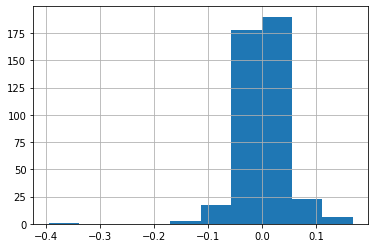

In [342]:
y_train.hist()

In [394]:
#regressor_full = RandomForestRegressor()
regressor_full = LinearRegression()
regressor_full.fit(X_full_train, y_train)
#print(classification_report(y_test, classifier_full.predict(X_full_test)))

LinearRegression()

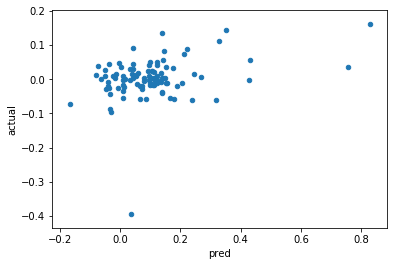

In [395]:
# Out of sample
import pandas as pd
from matplotlib import pyplot as plt
pdf = pd.DataFrame(dict(pred=regressor_full.predict(X_full_test), actual=y_test))

pdf.plot.scatter(0, 1)
#plt.xlim(-0.025, 0.025)
#plt.ylim(-0.15, 0.15)

In [396]:
pdf.corr()

,pred,actual
pred,1.000000,0.332945
actual,0.332945,1.000000


(-0.1, 0.1)

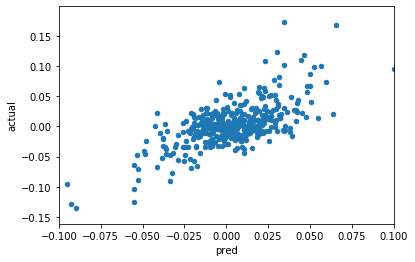

In [397]:
# In sample
# The in sample predictions from linear regression are not too overfit, compared to random forest - looks promising
import pandas as pd
from matplotlib import pyplot as plt
pdf = pd.DataFrame(dict(pred=regressor_full.predict(X_full_train), actual=y_train))

pdf.plot.scatter(0, 1)
plt.xlim(-0.1, 0.1)

In [398]:
feat_importance = pd.DataFrame({"importance": regressor_full.feature_importances_, "feat": X_full_train.columns})

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [348]:
feat_importance

,importance,feat
0,0.010040,index
1,0.011414,open
2,0.022711,high
3,0.015858,low
4,0.022280,close
...,...,...
75,0.008654,others_dr
76,0.017034,others_dlr
77,0.021043,others_cr
78,0.008210,pct_change


In [349]:
feat_importance.set_index("feat").sort_values(ascending=False, by="importance")

,importance
feat,
trend_dpo,0.039516
volume_adi,0.034599
trend_cci,0.030592
volume_obv,0.029656
trend_visual_ichimoku_a,0.028776
...,...
volatility_bbli,0.000416
trend_psar_down_indicator,0.000392
volatility_kchi,0.000119


Text(0.5, 1.0, 'TA Feature Importance for Predicting BTC returns')

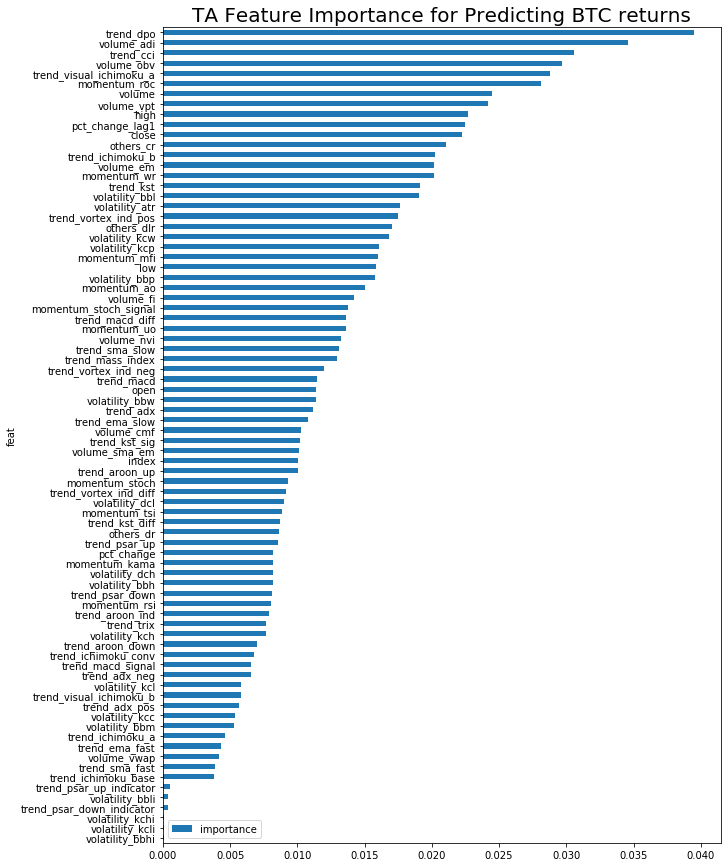

In [350]:
feat_importance.set_index("feat").sort_values(ascending=True, by="importance").plot.barh(figsize=(10, 15))
plt.title("TA Feature Importance for Predicting BTC returns", fontsize=20)

## Retrain on top features

Improved corrrelation by 5 percentage points!

In [426]:
top_feats = feat_importance.set_index("feat").importance.sort_values(ascending=False).head(20).index.values
#regressor_top = RandomForestRegressor()
regressor_top = LinearRegression()
regressor_top.fit(X_full_train[top_feats], y_train)

LinearRegression()

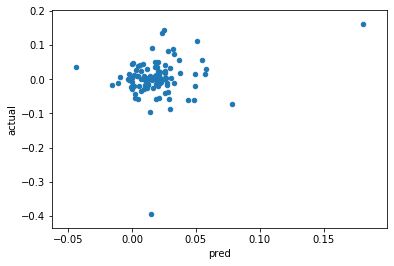

In [427]:
# Out of sample
import pandas as pd
from matplotlib import pyplot as plt
pdf = pd.DataFrame(dict(pred=regressor_top.predict(X_full_test[top_feats]), actual=y_test))
pdf['pos_pred'] = pdf.pred.gt(0)
pdf['pos_actual'] = pdf.actual.gt(0)

pdf.plot.scatter(0, 1)
#plt.xlim(-0.1, 0.1)
#plt.ylim(-0.10, 0.10)

In [428]:
pdf[["pred", "actual"]].corr()

,pred,actual
pred,1.000000,0.217987
actual,0.217987,1.000000


In [386]:
np.sqrt(pdf.actual.subtract(pdf.pred).pow(2).mean())

0.06142693380160941

In [390]:
# Overall accuracy
(pdf['pos_pred'] == pdf['pos_actual']).mean()

0.55

In [391]:
pdf['pos_actual'].mean()

0.56

                            OLS Regression Results                            
Dep. Variable:                 actual   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     12.22
Date:                Mon, 24 Aug 2020   Prob (F-statistic):           0.000713
Time:                        15:53:08   Log-Likelihood:                 146.11
No. Observations:                 100   AIC:                            -288.2
Df Residuals:                      98   BIC:                            -283.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0118      0.007     -1.680      0.0

(-0.1, 0.2)

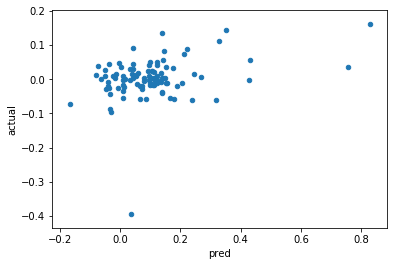

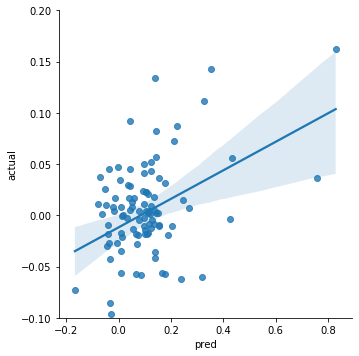

In [423]:
#import statsmodels.regression.linear_model as sm
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
np.random.seed(0)

comb = pdf[["pred", "actual"]].copy()

comb = comb.dropna()
X = pdf[["pred"]]
Y = pdf[["actual"]]
model2 = sm.OLS(Y,sm.add_constant(X), data=comb)
model_fit = model2.fit()
print(model_fit.summary())

#Plot
pdf[["pred", "actual"]].plot(kind='scatter', x="pred", y="actual")
#plt.ylim(-0.2, 0.2)
#plt.xlim(-0.2, 0.2)
#Seaborn
sns.lmplot(x="pred", y="actual", data=pdf)
plt.ylim(-0.1, 0.2)
#plt.xlim(-0.2, 0.2)

## Add lag features

Looks like adding lag features made it worse

In [402]:
df = get_crypto_data("BTC/USDT", "2019-01-01", "2020-08-23").reset_index().reset_index()

In [403]:
X = add_all_ta_features(
    df, open="open", high="high", low="low", close="close", volume="volume")

In [404]:
X = X.iloc[: -1]
X["pct_change"] = df.close.pct_change()
X["pct_change_lag1"] = X["pct_change"].shift()
X = X.fillna(-1)
y = df.close.pct_change().shift(-1).iloc[:-1]

In [405]:
if "dt" in X.columns:
    del X["dt"]

In [406]:
X_1 = X.shift().fillna(-1)
X_1.columns = [c + "_1" for c in X.columns]

In [407]:
X_comb = pd.concat([X, X_1], axis=1)

In [408]:
X_full_train, X_full_test, y_train, y_test = X_comb.iloc[:-100], X_comb.iloc[-100:], y.iloc[:-100], y.iloc[-100:]
#X_filtered_train, X_filtered_test = X_full_train[X_filtered.columns], X_full_test[X_filtered.columns]
X_filtered_train, X_filtered_test = X_full_train, X_full_test

In [411]:
regressor_full = LinearRegression()
#regressor_full = RandomForestRegressor()
regressor_full.fit(X_full_train, y_train)

LinearRegression()

(-0.15, 0.2)

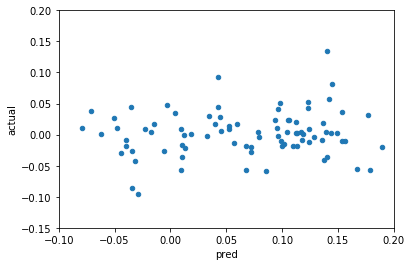

In [420]:
# Out of sample
import pandas as pd
from matplotlib import pyplot as plt
pdf = pd.DataFrame(dict(pred=regressor_full.predict(X_full_test), actual=y_test))

pdf.plot.scatter(0, 1)
plt.xlim(-0.1, 0.2)
plt.ylim(-0.15, 0.20)

In [424]:
pdf.corr()

,pred,actual
pred,1.000000,0.332945
actual,0.332945,1.000000


In [418]:
feat_importance = pd.DataFrame({"importance": regressor_full.feature_importances_, "feat": X_full_train.columns})

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [369]:
feat_importance.shape

(160, 2)

Text(0.5, 1.0, 'TA Feature Importance for Predicting BTC returns')

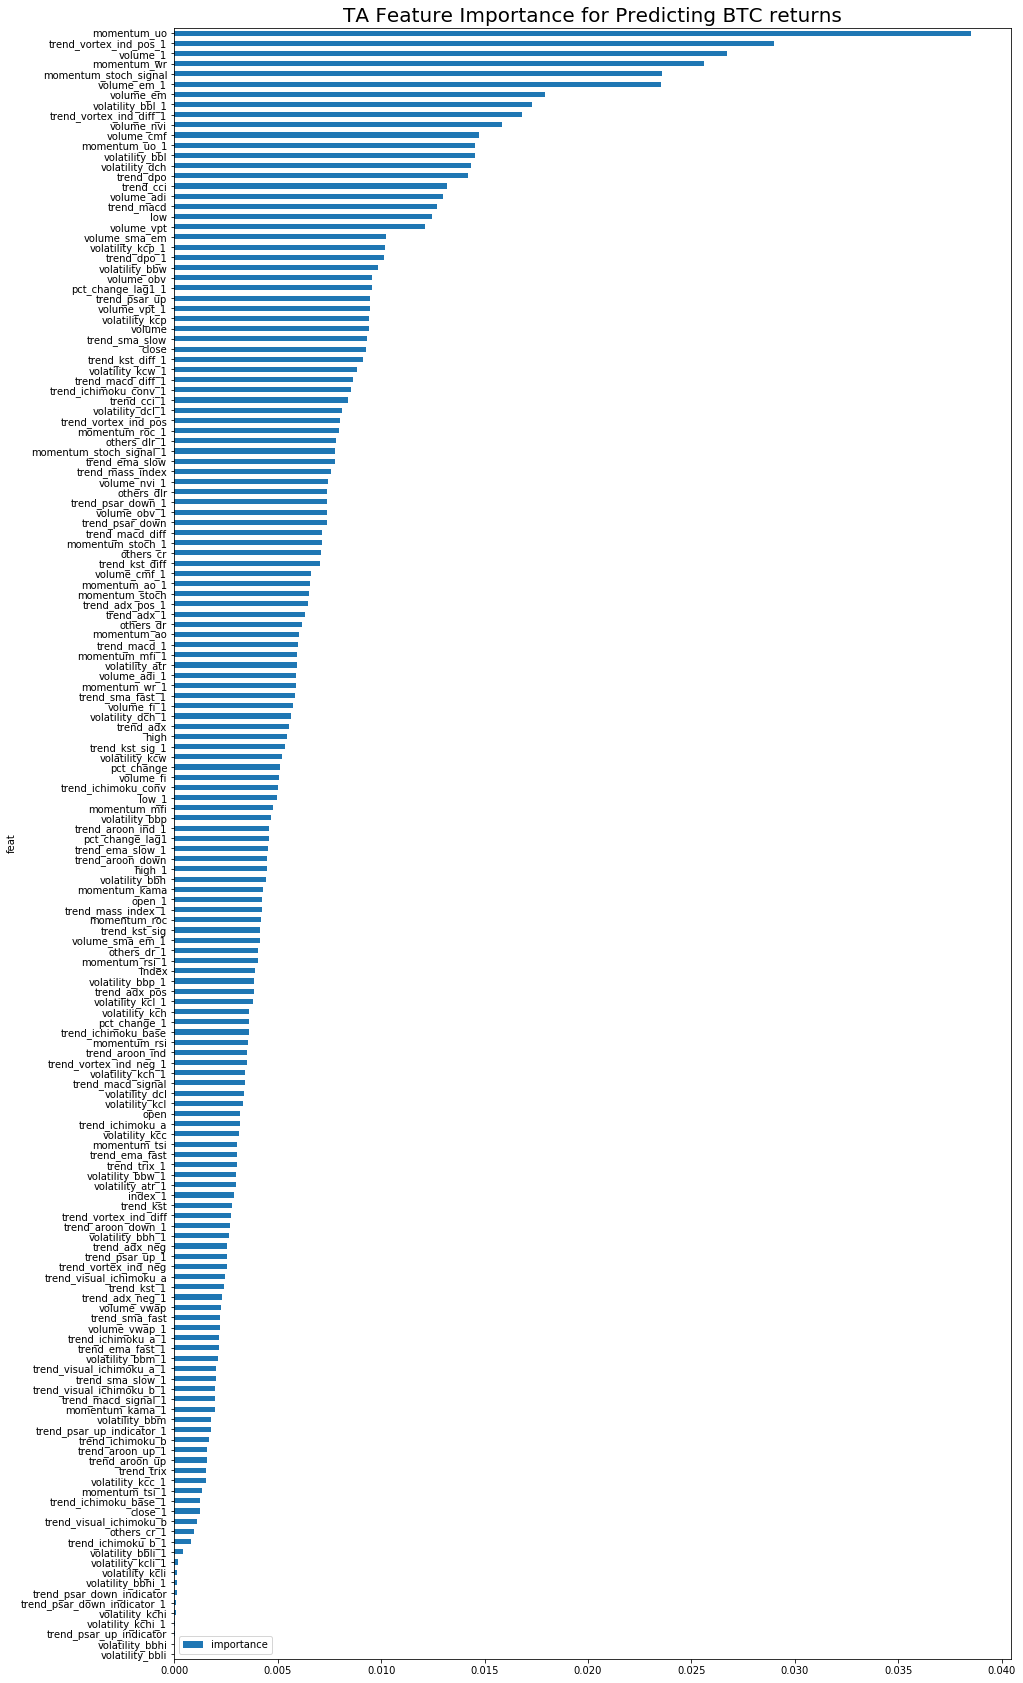

In [370]:
feat_importance.set_index("feat").sort_values(ascending=True, by="importance").plot.barh(figsize=(15, 30))
plt.title("TA Feature Importance for Predicting BTC returns", fontsize=20)

In [371]:
top_feats = feat_importance.set_index("feat").importance.sort_values(ascending=False).head(50).index.values
regressor_top = RandomForestRegressor()
regressor_top.fit(X_full_train[top_feats], y_train)

RandomForestRegressor()

(-0.15, 0.15)

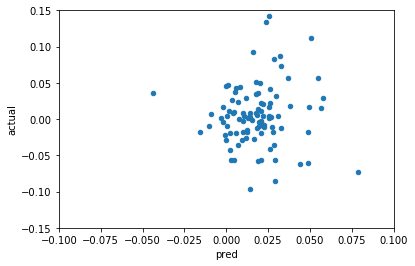

In [425]:
# Out of sample
import pandas as pd
from matplotlib import pyplot as plt
pdf = pd.DataFrame(dict(pred=regressor_top.predict(X_full_test[top_feats]), actual=y_test))

pdf.plot.scatter(0, 1)
plt.xlim(-0.1, 0.1)
plt.ylim(-0.15, 0.15)

In [373]:
pdf.corr()

,pred,actual
pred,1.00000,0.04023
actual,0.04023,1.00000


## Looking intro specifiying as classification problem

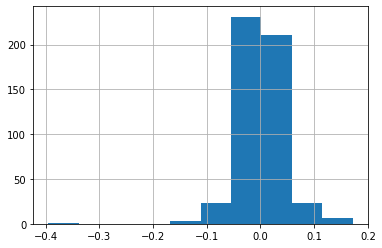

In [374]:
y.hist()

In [375]:
# One approach would be to specify as a ternary classification problem
#
y.describe()

count    499.000000
mean       0.002803
std        0.041368
min       -0.395048
25%       -0.013306
50%        0.001246
75%        0.018538
max        0.171968
Name: close, dtype: float64